In [1]:
import json
import re
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

from collections import Counter
from collections import defaultdict
from itertools import combinations


import networkx as nx
from conformity import attribute_conformity

from cdlib import algorithms
from cdlib.algorithms import eva
from cdlib import evaluation
from cdlib.algorithms import louvain
from cdlib import NodeClustering


import warnings
warnings.filterwarnings('ignore')

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'bayanpy', 'infomap', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [2]:
path = r'C:\Users\naomi\Documents\tesi 2025\prova ufficiale\dataset\\'

output_path = r"C:\Users\naomi\Documents\tesi 2025\prova ufficiale\grafi\IG\healthy\rete commenti sotto lo stesso post\\"

In [3]:
with open(path+'healthy_IG.json', 'r', encoding = 'utf-8') as f:
    dataset = json.load(f)

In [3]:
g = nx.Graph()
with open(output_path+'mentions_directed_network_from_comments_healthy_IG_with_account.edgelist') as f:
    for l in f:
        l = l.rsplit()
        if len(l)==3:
            g.add_edge(l[0], l[1], weight=float(l[2]))


with open(output_path + 'nodes_attributes_healthy_IG_nuovo.json', 'r') as f:
    node_data = json.load(f)

# Aggiungi attributi ai nodi presenti nella rete
for node, attributes in node_data.items():
    if node in g.nodes:
        g.nodes[node].update(attributes)

print("Nodi nella rete:", g.number_of_nodes())
print("Archi nella rete:", g.number_of_edges())
print("Density:", nx.density(g))
print("Assortativity:", nx.degree_assortativity_coefficient(g))

Nodi nella rete: 10059
Archi nella rete: 11877
Density: 0.00023478498137584
Assortativity: -0.6137080714647591


In [4]:
def count_nodes_by_threshold_on_graph_nodes(node_data, attribute, thresholds, graph):
    """
    Conta quanti nodi del grafo superano o meno ciascuna soglia dell'attributo dato.

    Args:
        node_data (dict): Dati dei nodi, es. {node_id: {'attribute_name': value, ...}}
        attribute (str): Nome dell'attributo da valutare (es. 'negative_comment_percentage')
        thresholds (list of int or float): Lista delle soglie
        graph (networkx.Graph): Il grafo contenente i nodi da considerare

    Returns:
        dict: Struttura {threshold: {'above': int, 'below': int}}
    """
    results = {}

    for threshold in thresholds:
        count_above = 0
        count_below = 0

        for node_id in graph.nodes:
            node_info = node_data.get(node_id, {})
            if attribute in node_info:
                value = node_info[attribute]
                if value >= threshold:
                    count_above += 1
                else:
                    count_below += 1

        results[threshold] = {
            'above': count_above,
            'below': count_below
        }

    return results


In [5]:
lst_threshold = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
attribute = 'negative_comment_percentage'
results = count_nodes_by_threshold_on_graph_nodes(node_data, attribute, lst_threshold, g)

# Stampa con percentuali sui nodi del grafo
for threshold in lst_threshold:
    counts = results[threshold]
    total = g.number_of_nodes()
    print(f"Threshold {threshold}%: >= {threshold}%: {counts['above']/total:.2%}, < {threshold}%: {counts['below']/total:.2%}")


Threshold 5%: >= 5%: 79.63%, < 5%: 20.37%
Threshold 10%: >= 10%: 76.33%, < 10%: 23.67%
Threshold 15%: >= 15%: 69.57%, < 15%: 30.43%
Threshold 20%: >= 20%: 63.61%, < 20%: 36.39%
Threshold 25%: >= 25%: 56.67%, < 25%: 43.33%
Threshold 30%: >= 30%: 47.51%, < 30%: 52.49%
Threshold 35%: >= 35%: 38.60%, < 35%: 61.40%
Threshold 40%: >= 40%: 35.38%, < 40%: 64.62%
Threshold 45%: >= 45%: 28.65%, < 45%: 71.35%
Threshold 50%: >= 50%: 26.88%, < 50%: 73.12%


In [6]:
def node_att_neg(node_data, perc, output_path):
    for node_id, info in node_data.items():
        neg = info.get('negative_comment_percentage')
        if neg is not None:
            node_data[node_id]['negative'] = neg >= perc
        else:
            node_data[node_id]['negative'] = False 
    
    output_file = os.path.join(output_path, f'node_attribute_healthy_IG_negative_{perc}.json')
    
    with open(output_file, 'w', encoding='utf-8') as jsonfile:
        json.dump(node_data, jsonfile, ensure_ascii=False, indent=2)

In [7]:
for threshold in lst_threshold:
    node_att_neg(node_data, threshold, output_path)

100%|██████████████████████████████████████████████████████████████████████████████| 8992/8992 [04:00<00:00, 37.37it/s]


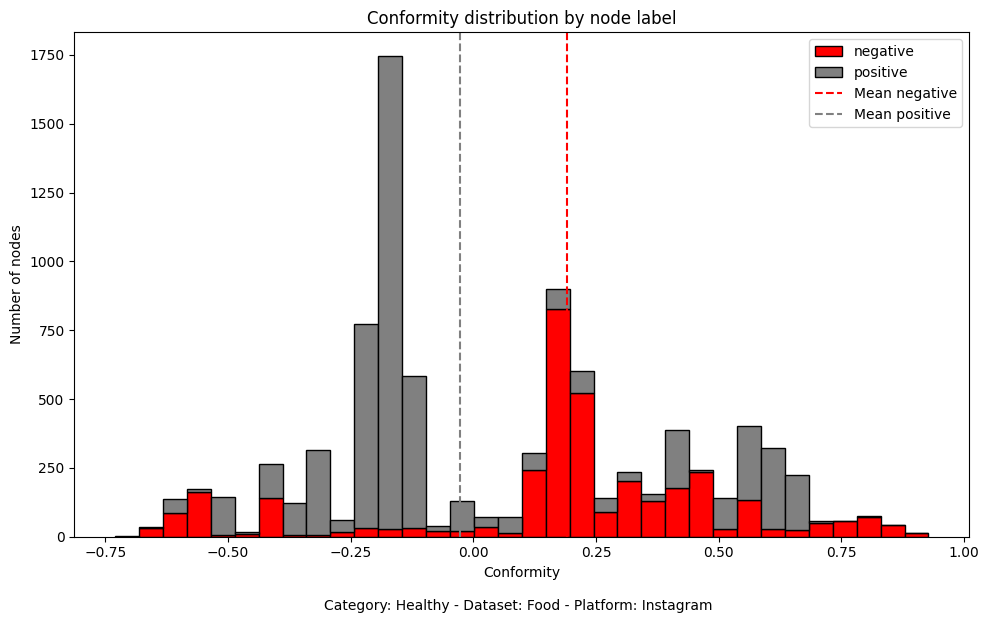

In [3]:
import os
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

description = 'Category: Healthy - Dataset: Food - Platform: Instagram '
type = 'healthy_ig_mentions'
save_path='fig_result'
if save_path:
    os.makedirs(save_path, exist_ok=True)

# === 1. Crea il grafo ===
g = nx.Graph()
with open(output_path + 'mentions_directed_network_from_comments_healthy_IG_with_account_nuovo.edgelist') as f:
    for l in f:
        l = l.rsplit()
        if len(l) == 3:
            g.add_edge(l[0], l[1], weight=float(l[2]))

# === 2. Carica attributi binari (positive/negative) ===
attribute = 'node_label'  # o il nome che hai usato nel JSON
input_file = os.path.join(output_path, 'nodes_attributes_healthy_IG_nuovo.json')

with open(input_file, 'r') as f:
    node_data = json.load(f)

# Aggiungi attributi ai nodi
for node, attributes in node_data.items():
    if node in g.nodes:
        g.nodes[node].update(attributes)

# === 3. Prendi la componente connessa più grande ===
largest_ccG = max(nx.connected_components(g), key=len)
G_connected = g.subgraph(largest_ccG).copy()

# === 4. Calcola la conformity ===
node_to_conformityG = attribute_conformity(G_connected, [2], ['node_label'], profile_size=1)
conformity_dictG = node_to_conformityG['2']['node_label']

# === 5. Separa valori di conformity in base al sentiment ===
conformity_positive = []
conformity_negative = []

for node, value in conformity_dictG.items():
    try:
        value = float(value)
        sentiment = node_data.get(node, {}).get('node_label')
        if sentiment == 'negative':
            conformity_negative.append(value)
        elif sentiment == 'positive':
            conformity_positive.append(value)
    except (ValueError, TypeError):
        print(f"⚠️ Nodo {node} ha valore non numerico: {value}")

# === 6. Crea bins comuni ===
all_conformity = conformity_negative + conformity_positive
bins = np.histogram_bin_edges(all_conformity, bins='auto')

# === 7. Plot ===
plt.figure(figsize=(10, 6))
plt.hist([conformity_negative, conformity_positive],
         bins=bins,
         stacked=True,
         label=['negative', 'positive'],
         color=['red', 'gray'],
         edgecolor='black')

plt.axvline(np.mean(conformity_negative), color='red', linestyle='--', label='Mean negative')
plt.axvline(np.mean(conformity_positive), color='gray', linestyle='--', label='Mean positive')

plt.xlabel('Conformity')
plt.ylabel('Number of nodes')
plt.title('Conformity distribution by node label')
plt.legend()
plt.tight_layout()
plt.figtext(
    0.525, -0.025,
    f"{description}",
    wrap=True, horizontalalignment='center', fontsize=10
)
if save_path:
    plt.savefig(f"{save_path}/{type}_conformity_distribution.png", dpi=300, bbox_inches='tight')
plt.show()
